#Background and Problem Statement
Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups, it’s like Slack.  Recently, there has been a dip in  activity on the user engagement.  My Job is figure out what could be causing the drop. 

##About this notebook.
This notebook is a working file that I will use to do my initial EDA and try to formulate hypotheses.  You should be able to follow my train of thought as I work through the problem by the comments and the code.  A final report style notebook will be produced that synthesizes all of the data and questions into a straightforward story.


In [0]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot  as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import scipy as sp
import datetime as datetime
from google.colab import drive

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

#EDA 
##Data import
First things first, I have to import the data in and merge the various tables into a single dataframe that I can work with.
I keep my files on my Google Drive, so I will have to mount it and read in the csv files.  This next line of code should be modified for the user's file setup.

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
dimension_rollup_periods = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data Challenge 2/dimension_rollup_periods.csv")
emails = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data Challenge 2/yammer_emails.csv")
events = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data Challenge 2/yammer_events.csv")
users = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data Challenge 2/yammer_users.csv")
                    

In [0]:
print(users.shape)
users.head()

In [0]:
print(events.shape)
events.head()

In [0]:
print(emails.shape)
emails.head(10)

In [0]:
print(dimension_rollup_periods.shape)
dimension_rollup_periods.tail()

## Data Processing
First things first, lets get all this data into one table.  We can merge on a couple of overlapping columns:

events emails and users - on user_id

use dimension_periods to generate periods...not sure how to do this yet though

###Thinking about the data
what kind of questions do we want to answer? what data do we need to do this?  

Initial thoughts:
1.) We are interested in customer engagement levels and why they dipped.  That is our primary concern.

- Are there any events that are responsible for the decline.
- Are email click throughs counted as engagement? do we even need them?
- Let's ignore it for now, and come back to it later, since it will add a ton of Nan values to our dataset


We don't need all the user information, in fact since we are looking at engagement, we can get rid of all the data pertaining to users who are not active yet, that is those that are pending.  This means we will be using the users df as a filter.


Similarly, we since we are interested in engagement, we don't need to worry about the signup_flow events, so we can get rid of those as well

1.)  Get rid of all ~active user_ids from users

2.)  Get rid of ~engagement data from events

3.)  Use a right join on users df to filter out unwanted data.

In [0]:
eu_df = pd.merge(events,users,on='user_id', how= 'left')

In [0]:
print(eu_df.shape)
print(eu_df.isnull().sum())
eu_df.head()

In [0]:
full_df = pd.merge(eu_df,emails,on=['user_id','occurred_at'], how='outer')

In [0]:
print(full_df.shape)
print(full_df.isnull().sum())
full_df.head()

In [0]:
ee_df = pd.merge(events,emails,on=['user_id','occurred_at'], how='outer')
full_df_2 = pd.merge(ee_df,users, on='user_id', how='left')

In [0]:
print(full_df_2.shape)
print(full_df_2.isnull().sum())
full_df_2.head()

In [0]:
users.info()

In [0]:
users['created_at'] = pd.to_datetime(users['created_at']).dt.date
users['activated_at'] = pd.to_datetime(users['activated_at']).dt.date

In [0]:
ud.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


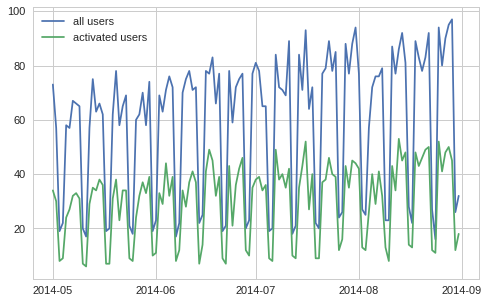

In [53]:
months = mdates.MonthLocator() 
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%Y-%m')
ud = users.groupby('created_at').size()
users['new'] = np.where(users['activated_at'].isnull(), 0, 1)
ud_new = users.groupby('created_at')['new'].sum()
mask =  np.arange('2014-05-01', '2014-09-02', dtype='datetime64[D]')
plt.plot()
ax = plt.gca()
ax.plot(mask,ud.loc[mask], mask, ud_new.loc[mask])
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
ax.legend(['all users','activated users'])

##First Insights
Here we have  a graph looking at the total number of new accounts added.  While we know the user engagement is dropping, the data here seems to show that the total user base is actually increasing in size, as the numbe of new users is increasing from month to month.  This could indicate that while newer users are being added, older users are engaging less.   The next step would be to look at existing users and seeing if any of them are jumping ship.

To probe this, firsts lets look at the users events and see which ones of them are declining, this weill also act as validation for our claim of growing user base, as we would expect to see increases in the number new accounts made.

In [0]:
eu_df['quarter_created'] = pd.PeriodIndex(pd.to_datetime(eu_df.created_at), freq='Q')

In [0]:
eu_df['occurred_at'] = pd.to_datetime(pd.to_datetime(eu_df['occurred_at']).dt.strftime('%Y-%m-%d'))

This gives use the total number of events per day for each 'age' group.  We will need to take this and resample it down so that its events per month and then we can look at some nice bar charts. 

In [0]:
quart_engagement = eu_df.groupby(['quarter_created','occurred_at'])['event_type'].size()

In [0]:
montlhy_engagement = eu_df
montlhy_engagement['events'] = 

In [0]:
montlhy_engagement.head()

In [0]:
qw_eng = eu_df.set_index('occurred_at').groupby('quarter_created').resample('M').size().to_frame('counts')

In [0]:
swap = qw_eng.swaplevel(0,1)

foo = pd.DataFrame(qw_eng.reset_index())

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


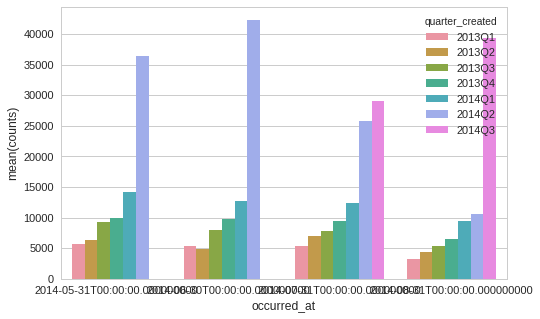

In [286]:
ax = sns.barplot(x="occurred_at",y="counts", hue="quarter_created", data=foo)

##New Insigts
From here we can see that older users are using the service less and less, and this has been hidden for the last several months as new cohorts are coming on board.  This makes sense with out last bit of evidence, showing that user base is growing every month with new users.  However, it looks like the drop off for the most recent month was more than the onboarding, which is why we saw the dip.

Based on all the information we collected, it seems like the older the user, the lower their engagement, and that newer user's engagement tends to outpace the loss in engagement from older users. However, in this particular instance, the loss in engagement outpaced newer user's engagement.


In [0]:
emails['occurred_at'] = pd.to_datetime(pd.to_datetime(emails['occurred_at']).dt.date)

In [0]:
foo = emails.groupby(['occurred_at','action']).count()


In [0]:
foo.head(100)

In [35]:
#ax = sns.countplot(x='occurred_at',hue='action', data=emails)
bar = foo.unstack(level=1)
bar.head()

user_id                                     \
action      email_clickthrough email_open sent_reengagement_email   
occurred_at                                                         
2014-05-01                61.0      145.0                     7.0   
2014-05-02                82.0      142.0                    39.0   
2014-05-03                23.0       23.0                    27.0   
2014-05-04                21.0       22.0                    25.0   
2014-05-05               115.0      255.0                    34.0   

                                        user_type             \
action      sent_weekly_digest email_clickthrough email_open   
occurred_at                                                    
2014-05-01               467.0               61.0      145.0   
2014-05-02               441.0               82.0      142.0   
2014-05-03                 NaN               23.0       23.0   
2014-05-04                 NaN               21.0       22.0   
2014-05-05               760.0              115.0      255.0   

                                                        
action      sent_reengagement_email sent_weekly_digest  
occurred_at                                             
2014-05-01                      7.0              467.0  
2014-05-02                     39.0              441.0  
2014-05-03                     27.0                NaN  
2014-05-04                     25.0                NaN  
2014-05-05                     34.0              760.0

In [36]:
bar.index

DatetimeIndex(['2014-05-01', '2014-05-02', '2014-05-03', '2014-05-04',
               '2014-05-05', '2014-05-06', '2014-05-07', '2014-05-08',
               '2014-05-09', '2014-05-10',
               ...
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31'],
              dtype='datetime64[ns]', name='occurred_at', length=123, freq=None)

In [0]:
weekly_summary = pd.DataFrame()
weekly_summary['email_clickthrough'] = bar.user_type.email_clickthrough.resample('W').sum()
weekly_summary['email_open'] = bar.user_type.email_open.resample('W').sum()
weekly_summary['sent_reengagement_email'] = bar.user_type.sent_reengagement_email.resample('W').sum()
weekly_summary['sent_weekly_digest'] = bar.user_type.sent_weekly_digest.resample('W').sum()

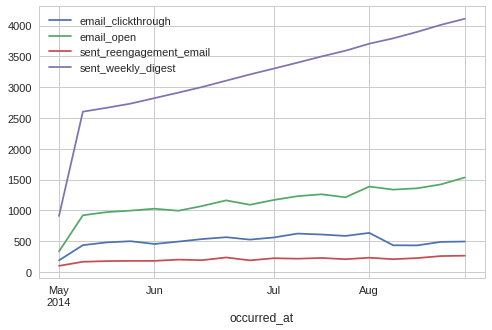

In [39]:
weekly_summary.plot(kind='line')

##New Insight
the week of interest (2014-07-28) shows a drop off in total clickthroughs immediately after ,meaning users are opening links from the weekly email  less. However, there is also an increase in total emails sent. This corroborate out theory of an increase in the total userbase while there is simultaneously a dip in the user engagement that can be attributed to a drop in older user engagement while regular growth continues to rise as usual.

#Take Away
Based on all the information we collected, it seems like the older the user, the lower their engagement, and that newer user's engagement tends to outpace the loss in engagement from older users. However, at this point in time, the loss in engagement outpaced newer user's engagement, and coincided with a reduction in email click throughs by all users. I would suspect that this might have something to do with a change in optimization of emails.  I would probably take this information to the product director and those in other departments to see if there was something new/a change that impacted our email/emails system